# Background
The problem in question is based on the paper **Example Rules For The ENEXA Use Case At DATEV**. You'll find the paper in this folder if you want to familiarise yourself with the context. The aim of this notebook is to derive inference problems from three example rules that represent accounting practices and implement MAP inference as a QUBO.

In [1]:
!pip install shrinking

ERROR: Could not find a version that satisfies the requirement shrinking (from versions: none)
ERROR: No matching distribution found for shrinking


## Formulate quadratic program

In [2]:
import tnreason

In [3]:
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

mdl = Model("Buchungsbeispiel")

A_x = mdl.binary_var("A(x)")
S_z = mdl.binary_var("S(z)")
M_z = mdl.binary_var("M(z)")
U_z = mdl.binary_var("U(z)")
B_y = mdl.binary_var("B(y)")
vB_yx = mdl.binary_var("vB(y,x)")
hL_xy = mdl.binary_var("hL(x,y)")
hB_xz = mdl.binary_var("hB(x,z)")

## Slack variable enforcement
b_2 = mdl.binary_var("b_2")
b_3 = mdl.binary_var("b_3")

## Rule weight in MLN
w_1 = 10
w_2 = 10
w_3 = 10
tw = 100

## MAP Inference as QUBO
mdl.maximize(
    w_1 - w_1 * S_z + w_1 * S_z * M_z
  + w_2 - w_2 * b_2 + w_2 * b_2 * A_x
  + w_3 - w_3 * b_3 + w_3 * b_3 * U_z
  + tw * b_2 * hL_xy + tw * b_2 * vB_yx - tw * b_2 * 3/2
  + tw * b_3 * A_x + tw * b_3 * vB_yx + tw * b_3 * B_y + tw * b_3 * hB_xz + tw * b_3 * M_z - tw * b_3 * 9/2
)

qp = from_docplex_mp(mdl)
print(qp.prettyprint())

Problem name: Buchungsbeispiel

Maximize
  10*A(x)*b_2 + 100*A(x)*b_3 + 100*B(y)*b_3 + 100*M(z)*b_3 + 10*S(z)*M(z)
  + 10*U(z)*b_3 + 100*hB(x,z)*b_3 + 100*hL(x,y)*b_2 + 100*vB(y,x)*b_2
  + 100*vB(y,x)*b_3 - 10*S(z) - 160*b_2 - 460*b_3 + 30

Subject to
  No constraints

  Binary variables (10)
    A(x) S(z) M(z) U(z) B(y) vB(y,x) hL(x,y) hB(x,z) b_2 b_3



## Quadratic program to QUBO

In [4]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print(qubo.prettyprint())

exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo)

solutions = [s for s in exact_result.samples if s.fval == exact_result.fval]
for solution in solutions:
    print(solution)

print("Objective function value: ", solution.fval)
print("Number of solutions: ", len(solutions))

Problem name: Buchungsbeispiel

Minimize
  -10*A(x)*b_2 - 100*A(x)*b_3 - 100*B(y)*b_3 - 100*M(z)*b_3 - 10*S(z)*M(z)
  - 10*U(z)*b_3 - 100*hB(x,z)*b_3 - 100*hL(x,y)*b_2 - 100*vB(y,x)*b_2
  - 100*vB(y,x)*b_3 + 10*S(z) + 160*b_2 + 460*b_3 - 30

Subject to
  No constraints

  Binary variables (10)
    A(x) S(z) M(z) U(z) B(y) vB(y,x) hL(x,y) hB(x,z) b_2 b_3

SolutionSample(x=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), fval=-130.0, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)
Objective function value:  -130.0
Number of solutions:  1


## Graph Representation of the QUBO

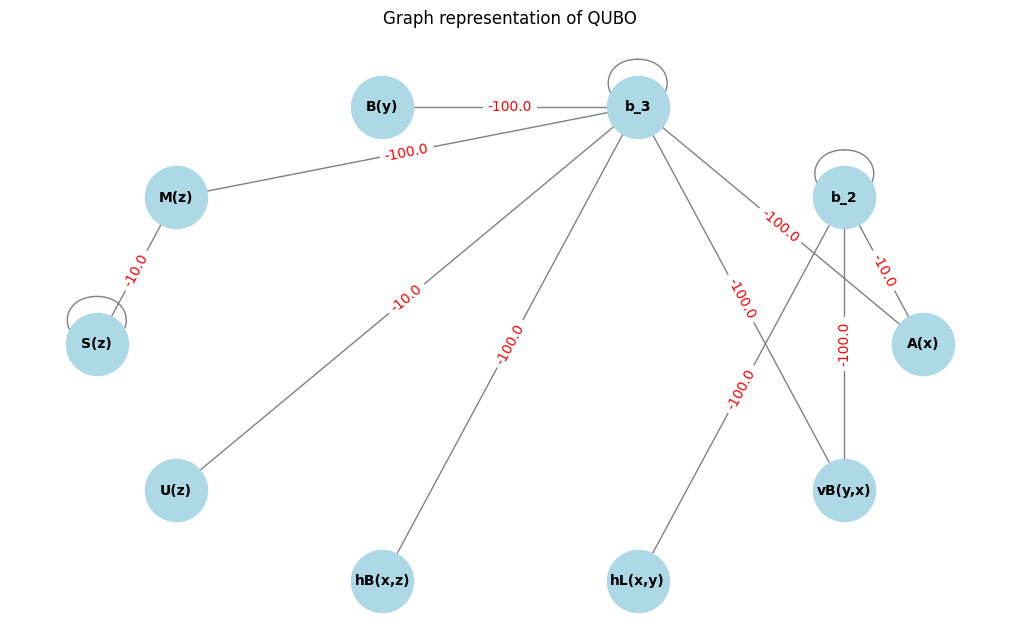

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
# Define the QUBO interactions as a weighted graph
qubo_edges = [('A(x)', 'b_2', -10.0), ('A(x)', 'b_3', -100.0), ('B(y)', 'b_3', -100.0), ('M(z)', 'b_3', -100.0), ('S(z)', 'M(z)', -10.0),
               ('U(z)', 'b_3', -10.0), ('hB(x,z)', 'b_3', -100.0), ('hL(x,y)', 'b_2', -100.0), ('vB(y,x)', 'b_2', -100.0), ('vB(y,x)', 'b_3', -100.0), ('S(z)', 'S(z)', 10.0), ('b_2', 'b_2', 160.0),
                ('b_3', 'b_3', 460.0)]
# Create a graph
G = nx.Graph()
G.add_weighted_edges_from(qubo_edges)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G)  # Positioning nodes with spring layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title("Graph representation of QUBO")
plt.show()

## Try to solve directly with QAOA

In [34]:
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, NELDER_MEAD
from qiskit_optimization.algorithms import OptimizationResultStatus, SolutionSample
import numpy as np
from typing import List, Tuple

def get_beta_gamma_sequential(n, beta, gamma):
    return [beta] * n + [gamma] * n

def get_beta_gamma_alternating(n, beta, gamma):
    return [beta, gamma] * n

def step(step:int,params:np.array,mean:float,error:float):
    print(f'step: {step}, mean: {mean}, params: {params}')

def find_greatest_absolute_weight(qubo):
    weight_dict = qubo.objective.quadratic.to_dict() | qubo.objective.linear.to_dict()
    weights = weight_dict.values()
    return max(abs(weight) for weight in weights)

def get_beta(a, d):
    return (1/a)*np.arctan(1/np.sqrt(d-1))

qaoa_p = len(qubo.variables)

greatest_weight = find_greatest_absolute_weight(qubo)
beta = get_beta(greatest_weight, 2)

beta_gamma = get_beta_gamma_alternating(qaoa_p, 0, np.pi/8)

shots = 4000
sampler = Sampler(run_options={
        "shots": shots,
        "seed": 42,
        "max_parallel_threads": 0,
        "max_parallel_experiments": 0,
        "max_parallel_shots": 1,
        "statevector_parallel_threshold": 8,
        "device": "CPU"
    })
optimizer = COBYLA()
qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=qaoa_p, #callback=step,
               initial_point=beta_gamma)
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)

qaoa_solutions = [s for s in qaoa_result.samples if s.fval == exact_result.fval]
for solution in qaoa_solutions:
    print(solution)

#print("Objective function value: ", qaoa_solutions.fval)
print("Number of solutions: ", len(qaoa_solutions))

SolutionSample(x=array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]), fval=-130.0, probability=0.002, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), fval=-130.0, probability=0.0005, status=<OptimizationResultStatus.SUCCESS: 0>)
Number of solutions:  2


Total variables:  10
P:  10
Shots:  4000


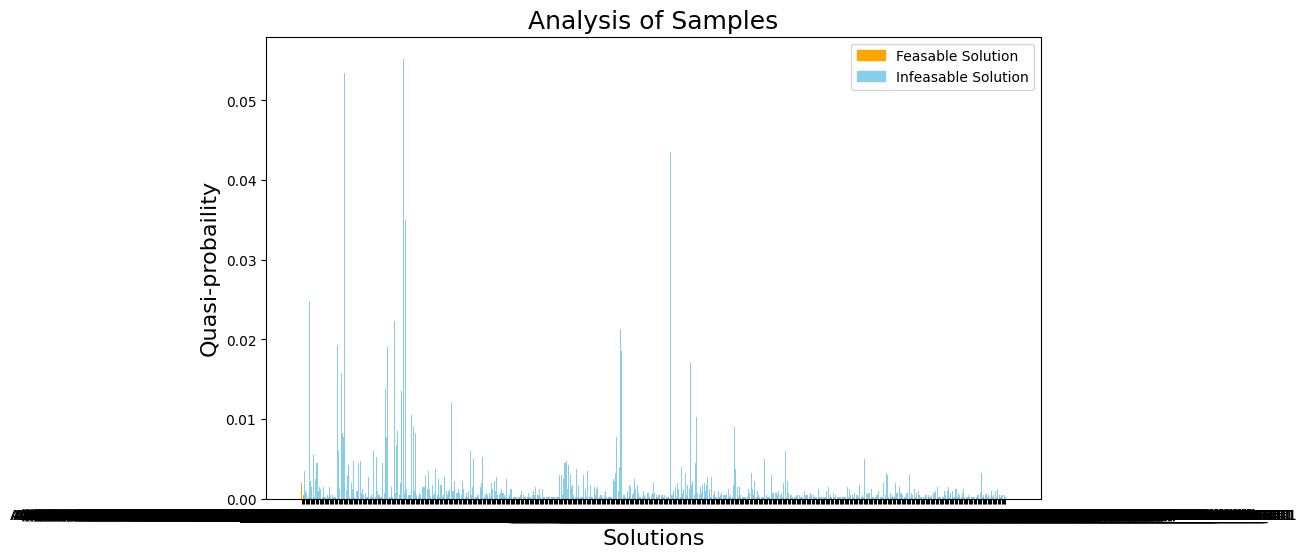

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def get_solutions_for_plot(result):
    solutions = []
    fval = result.fval
    for sample in result.samples:
        if sample.fval == fval:
            solutions.append(sample)
    return {
    " ".join(f"{result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))
    for s in solutions
    }

def get_samples(data):
    return {
    " ".join(f"{data.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in data.samples
    }

solutions_for_plot = get_solutions_for_plot(qaoa_result)
samples_for_plot = get_samples(qaoa_result)

labels = list(samples_for_plot.keys())
values = list(samples_for_plot.values())

# Define color scheme, with one bar having a different color
colors = ['orange' if label in solutions_for_plot else 'skyblue' for label in labels]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)

# Labeling
plt.xlabel("Solutions", fontsize=16)
plt.ylabel("Quasi-probaility", fontsize=16)
plt.title("Analysis of Samples", fontsize=18)
#plt.xticks(rotation=70, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for readability

# Create custom legend
correct_patch = mpatches.Patch(color='orange', label='Feasable Solution')
incorrect_patch = mpatches.Patch(color='skyblue', label='Infeasable Solution')
plt.legend(handles=[correct_patch, incorrect_patch])

print("Total variables: ", len(qaoa_result.variables))
print("P: ",qaoa_p)
print("Shots: ",shots)
plt.show()

## QUBO to WMC (Weighted Max-Cut)

This is an alternative approach, instead of trying to solve the QUBO directly with QAOA, we use a graph shrinking technique called RQAOA.

In [8]:
from shrinking.graph_shrinking import solve_maxcut_shrinking
from shrinking.graph_shrinking import collapse_graph
from problem_trafos.weighted_maxcut import transform_qubo_matrix_to_wmc

quadratic = qubo.objective.quadratic.to_array(symmetric=True) * (-1)
linear = qubo.objective.linear.to_array() * (-1)

GW, offset = transform_qubo_matrix_to_wmc(quadratic, linear)

ModuleNotFoundError: No module named 'shrinking'

## Shrink with RQAOA
RQAOA stands for **rekursive quantum approximation optimisation algorithm**. The algorithm reduces the graph and therefore the number of variables without losing information. It optimizes parameters for a fixed-depth QAOA circuit and also includes correlation measurements to guide problem simplification. Strongly correlated variables are fixed or merged based on quantum measurements, iteratively shrinking the problem graph. In essence quantum-classical loops simplifiy the problem step by step until the remaining small problem can be exactly solved using classical methods.

### Key Steps

#### 1. Identifying Strong Correlations
- **QAOA State Preparation**:
  - Prepare a parameterized quantum state using a circuit that alternates between the cost unitary $ U_C(\gamma) $ and mixing unitary $ U_B(\beta) :
    \psi(\vec{\gamma}, \vec{\beta})\rangle = \prod\limits_{k=1}^{p} U_B(\beta_k) U_C(\gamma_k) |s\rangle $
  - Compute the expectation values of the cost Hamiltonian $ \langle H_C \rangle $ and pairwise correlations  $ \langle Z_i Z_j \rangle $.

- **Correlation Analysis**:
  - After running the quantum circuit, measure pairwise correlations between variables (qubits) to identify relationships:
    - $ \langle Z_i Z_j \rangle \approx +1 $: Variables $i$ and $j$ are likely to take the same value in the solution.
    - $ \langle Z_i Z_j \rangle \approx -1 $: Variables $i$ and $j$ are likely to take opposite values.
  - Use these correlations to understand interactions between variables.

#### 2. Fixing Variables
- **Variable Fixing Rules**:
  - Based on measured correlations:
    - If $\langle Z_i Z_j \rangle \approx +1$, treat variables $i$ and $j$ as a single "super-variable" with the same value.
    - If $\langle Z_i Z_j \rangle \approx -1$, fix one variable and update the other accordingly.

- **Graph Simplification**:
  - Fixing variables reduces the problem size:
    - Remove or merge the corresponding qubits and edges in the problem graph.
    - Create a simplified problem instance for the next iteration.

#### 3. Iterative Problem Refinement
- **Quantum Optimization**:
  - Run QAOA on the current problem instance to measure correlations.
  - Simplify the problem by fixing variables and reducing the graph.
  - Repeat the process iteratively, shrinking the graph at each step.

- **Stopping Condition**:
  - Stop when the problem size is small enough for classical solution methods.

#### 4. Final Classical Optimization
- When the graph becomes sufficiently small (e.g., fewer than 10 variables), solve the reduced problem exactly using classical methods.
- Combine the partial solution with fixed variables to reconstruct the solution to the original problem.


In [ ]:
num_targetqubits = 5
recal_interval = 4
# Adds one additional variable to the max-cut solution
solve_maxcut_shrinking(GW,"QAOA",num_targetqubits=num_targetqubits,recal_interval=recal_interval)

In [ ]:
# Analytical computation of the correlations
GS, mem, offset = collapse_graph(GW,"QAOA",num_targetqubits=num_targetqubits,recal_interval=recal_interval)

## Reduced Max-Cut Graph

In [ ]:
# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.circular_layout(GS)  # Positioning nodes with spring layout
nx.draw(GS, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(GS, 'weight')
nx.draw_networkx_edge_labels(GS, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title("Graph representation of reduced Max-Cut")
plt.show()

## Shrinked WMC graph back to QUBO

In [ ]:
from qiskit_optimization.applications import Maxcut
GS_matrix = nx.to_numpy_array(GS)
max_cut = Maxcut(GS_matrix)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())
qubo_shrinked = conv.convert(qp)
print(qubo_shrinked.prettyprint())

## Solve reduced QUBO with classical solver

In [ ]:
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo_shrinked)

solutions = [s for s in exact_result.samples if s.fval == exact_result.fval]
for solution in solutions:
    print(solution)

print("Objective function value: ", solution.fval)
print("Number of solutions: ", len(solutions))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def get_solutions_for_plot(result):
    solutions = []
    fval = result.fval
    for sample in result.samples:
        if sample.fval == fval:
            solutions.append(sample)
    return {
    " ".join(f"{result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))
    for s in solutions
    }

def get_samples(data):
    return {
    " ".join(f"{data.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in data.samples
    }

solutions_for_plot = get_solutions_for_plot(exact_result)
samples_for_plot = get_samples(exact_result)

labels = list(samples_for_plot.keys())
values = list(samples_for_plot.values())

# Define color scheme, with one bar having a different color
colors = ['orange' if label in solutions_for_plot else 'skyblue' for label in labels]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)

# Labeling
plt.xlabel("Solutions", fontsize=16)
plt.ylabel("Quasi-probaility", fontsize=16)
plt.title("Analysis of Samples", fontsize=18)
plt.xticks(rotation=70, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for readability

# Create custom legend
correct_patch = mpatches.Patch(color='orange', label='Feasible Solution')
incorrect_patch = mpatches.Patch(color='skyblue', label='Unfeasible Solution')
plt.legend(handles=[correct_patch, incorrect_patch])

print("Total variables: ", len(exact_result.variables))
print("P: ",qaoa_p)
print("Shots: ",shots)
plt.show()

## Reconstruct the solution based on the original problem

In [ ]:
from shrinking.graph_utils import recreate, maxcut_obj

def bitstring_to_sol(bitstring, Gs):
    out = {}
    for node, bit in zip(list(Gs.nodes()), list(bitstring)):
        out[node] = bit

    return out

def get_solution(input_list):
    if input_list[0] == 0:
        transformed_list = [1 - x for x in input_list]
    else:
        transformed_list = input_list
    return transformed_list[1:]  # Remove the first element

In [ ]:
total_x =  recreate(bitstring_to_sol(exact_result.x, GS), mem, len(G.nodes())+1)

print(get_solution(total_x))

cut = maxcut_obj(total_x,GW)
print(cut)

colors = ["r" if total_x[i] == 0 else "c" for i in range(len(G.nodes()))]
print(colors)

In [ ]:
[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]